<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Este caderno serve como Análise Exploratória de Dados para Logística II, como parte de um curso da EBAC (Escola Britânica de Artes Criativas e Tecnologia).

O projeto utilizou o banco de dados Loggi, startup brasileira de logística. Loggi é uma startup brasileira unicórnio de tecnologia com foco principal em logística. Iniciou suas operações em 2013, inicialmente cuidando da entrega de documentos. Ao longo de dois anos, expandiu seus serviços para incluir o setor de comércio eletrônico. Desde 2017, a Loggi também atua na entrega de alimentos.

O conjunto de dados foi adquirido através do GitHub do repositório Loggi Benchmark for Urban Deliveries (BUD). Este repositório contém dados e códigos relacionados a desafios típicos enfrentados por empresas de logística, como otimizar rotas de entrega e alocar entregas a uma frota com capacidade limitada. É representativo dos desafios que a startup enfrenta no dia a dia, principalmente no que diz respeito à sua escala.

O objetivo desta análise é explorar o conjunto de dados e identificar áreas potenciais para melhoria.

## 2\. Dados

Os dados foram consolidados em um único arquivo JSON pelo professor da disciplina para a cidade de Brasília.

O dado bruto é um arquivo do tipo JSON com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional. Exemplo:


```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...



Onde:
- **name**: uma `string` com o nome único da instância;
- **region**: uma `string` com o nome único da região do **hub**;
- **origin**: um `dict` com a latitude e longitude da região do **hub**;
- **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
- **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.

Sendo que:
- **id**: uma `string` com o id único da **entrega**;
- **point**: um `dict` com a latitude e longitude da **entrega**;
- **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

## 3\. Pacotes e Bibliotecas

In [1]:
# Download

 # Deliveries HUB Loggi
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

 # Geodata
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

 # Mapa
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [2]:
!pip3 install --upgrade haversine     # haversine-2.8.0
!pip3 install --upgrade geopandas     # geopandas-0.14.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
# Importação das Bibliotecas
import json
import geopy
import geopandas

import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from haversine import haversine, Unit                                           # Calculo de distância

# crédito: https://www.kaggle.com/code/eugabrielolegario/eda-logistics-loggi-bud/notebook
def distancia_hub_del(lat_hub, lng_hub, lat_del, lng_del):
    point_hub = (lat_hub, lng_hub)
    point_del = (lat_del, lng_del)
    return round(haversine(point_hub, point_del, unit='km'), 2)

## 4\. Exploração de Dados e Manipulação

Nesta etapa, os dados “brutos” serão preparado para análises posteriores, reconhecendo, normalizando e transformando-os em informações mais estruturadas.

### 4.1\. Deliveries HUB Loggi
Organiza dos dados brutos do arquivo deliveries.json em um DataFrame (deliveries).



In [4]:
# Dados (deliveries.json) em um dict
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Dado Bruto (data) no Pandas.
deliveries_df = pd.DataFrame(data)

# Processamento da Coluna "origin"
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

 # Método merge | “inner”. Mantem os valores comuns em ambos os lados (left | right) do dataframes
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

 # Remover a coluna "origin" e renomeia as novas colunas
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# Processamento da Coluna "deliveries"

 # O método explode converte cada elemento de uma coluna(s) específica em uma linha.
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

 # Processa a linha de dados exploded, armazena e renomeia a coluna correta
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

 # Remove a coluna "deliveries"
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

### 4.2\. Distância do HUB e Deliveries
Acrescenta ao DataFrame (deliveries) a coluna de Distância, em km, do HUB até a entrega, por meio da longitude e latitude de ambos. Para realizar esse cálculo é utilizado a função haversine do python.

In [5]:
# crédito: https://www.kaggle.com/code/eugabrielolegario/eda-logistics-loggi-bud/notebook

# Cria lista de lat e lng para o hub e delivery
lat_hub = deliveries_df['hub_lat'].tolist()
lon_hub = deliveries_df['hub_lng'].tolist()
lat_del = deliveries_df['delivery_lat'].tolist()
lon_del = deliveries_df['delivery_lng'].tolist()

distancia = []
for lat_hub,lon_hub,lat_del,lon_del in zip(lat_hub,lon_hub,lat_del,lon_del):
  x = distancia_hub_del(lat_hub,lon_hub,lat_del,lon_del)
  distancia.append(x)

deliveries_df['distancia_km'] = distancia


### 4.3\. Dados de Geolocalização dos Deliveries
Devido à quantidade de dados, as informações de cidade e bairro das entregas são obtidos por meio do arquivo deliveries-geodata.csv.

In [6]:
# Leitura do arquivo
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
#deliveries_df.head()


### 4.4\. Controle de Qualidade

In [7]:
# Formato do DataFrame
deliveries_df.shape

(636149, 11)

In [8]:
# Nome das colunas do DataFrame
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat', 'distancia_km',
       'delivery_city', 'delivery_suburb'],
      dtype='object')

In [9]:
# Resumo do Dataframe
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   distancia_km      636149 non-null  float64
 9   delivery_city     634447 non-null  object 
 10  delivery_suburb   476264 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 53.4+ MB


In [10]:
# Verifica se apresenta algum NaN
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
distancia_km        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [11]:
# Quantifica NaN
deliveries_df.isnull().sum()

name                     0
region                   0
hub_lng                  0
hub_lat                  0
vehicle_capacity         0
delivery_size            0
delivery_lng             0
delivery_lat             0
distancia_km             0
delivery_city         1702
delivery_suburb     159885
dtype: int64

In [12]:
deliveries_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
delivery_city,634447,38,Brasília,148983
delivery_suburb,476264,167,Brasília,53795


In [13]:
deliveries_df.select_dtypes('int').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [14]:
deliveries_df.select_dtypes('float').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355
distancia_km,636149.0,7.095050,5.341920,0.000000,3.680000,5.530000,8.890000,67.920000


## 5\. Visualização

### 5.1\. Mapa de entregas por região

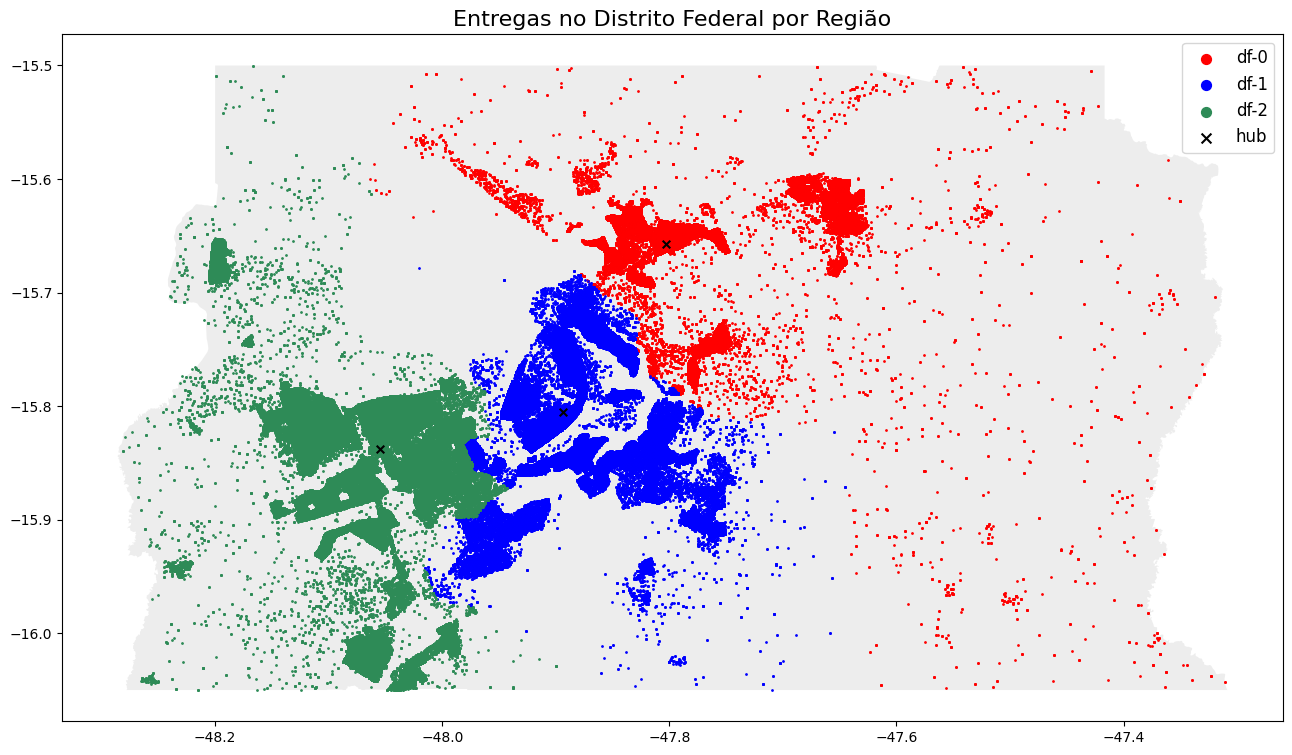

In [15]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
#mapa.head()

# Cria o DataFrame geo_hub_df através do DataFrame deliveries_df.
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
#geo_hub_df.head()

# Cria o DataFrame geo_deliveries_df através do DataFrame deliveries_df.
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
#geo_deliveries_df.head()

# cria o plot vazio
fig, ax = plt.subplots(figsize = (40/2.54, 40/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 12})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

**Insights:**

* Os HUBs estão bem localizados.
* O df-0 e df-2 apresentam as maiores distâncias em relação aos respectivos HUBs, provável que são entregas esporádicas.
* O HUB df-1 deve realizar as entregas mais rápidas, devido às menores distâncias e por estar centralizado em relação as entregas. Em seguida, o df-2 pelos mesmos motivos, apesar de algumas entregas mais distantes e por último df-0.



### 5.2\. Distâncias dos HUB e Deliveries

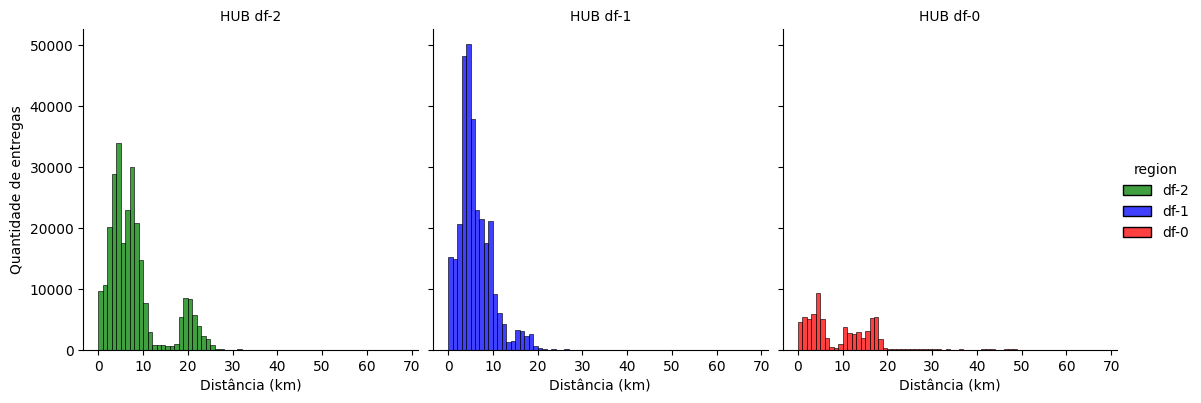

In [16]:
# Histograma das distâncias dos HUB e Deliveries para cada região
dis_graphic = sns.displot(data=deliveries_df, x="distancia_km",col="region",hue="region",multiple="stack",binwidth=1,palette=['g','b','r'])
dis_graphic.set_axis_labels("Distância (km)", "Quantidade de entregas")
dis_graphic.set_titles("HUB {col_name}")
dis_graphic.figure.set_size_inches(w=30/2.54, h=10/2.54)

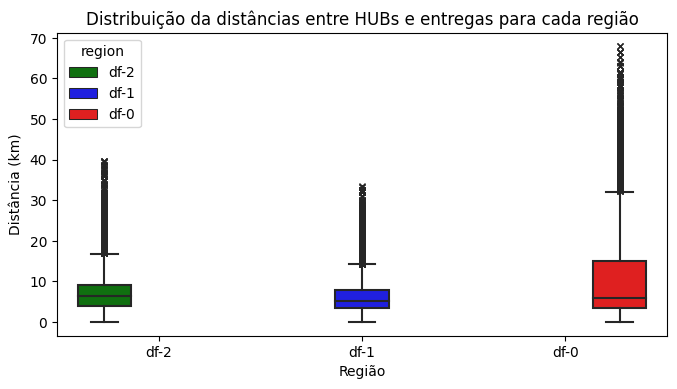

In [17]:
# Boxplot das distâncias dos HUB e Deliveries para cada região

box_graphic = sns.boxplot(data=deliveries_df,x="region",y="distancia_km",hue="region",flierprops={"marker": "x"},palette=['g','b','r'])
box_graphic.set(title='Distribuição da distâncias entre HUBs e entregas para cada região', xlabel="Região", ylabel="Distância (km)")
box_graphic.figure.set_size_inches(w=20/2.54, h=10/2.54)

**Insights**

Os gráficos de distância e quantidade de entregas por região coraboram com a visualização do mapa de localização dos HUBs e deliveries.

* **HUB df-0:**
  * Possui a menor quantidade de entrega dentre os HUBs com mediana próximo de 10 km e valores discrepantes/outliers acima de 30 km.
  * As entregas estão distribuidas entre 0 a 20 km de distância, e poucas entregas entre 20 a 70 km. Comprovando o insight do mapa "Entregas no Distrito Federal por Região".
  * Alguns veículos terão rotas de longas distâncias com baixa ocupação de carga no decorrer do percurso.
  * Se todos os HUBs possuem a mesma capacidade, então o HUB df-0 é aquele que apresenta maior ociosidade de quantidade de entrega ou maior capacidade disponivel para realizar entregas.

* **HUB df-1:**
  * Possui a maior quantidade de entregas dentre os HUBs com mediana próximo de 5 km e valores de outliers acima de 18 km.
  * Em sua maioria a distância está entre 0 a 10 km, em menor quantidade entre 10 e 30 km.

* **HUB df-2:**
  * Possui mediana próximo de 8 km e valores outliers acima de 19 km.
  * A distribuição das entregas é bimodal, 0 a 10 km e 19 a 25 km.





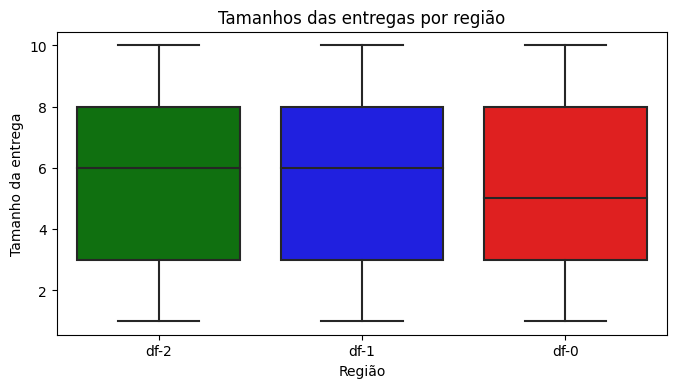

In [18]:
# Boxplot de tamanho da entrega para cada região
box_graphic_volume = sns.boxplot(data=deliveries_df, y='delivery_size', x='region', palette=['g','b','r'])
box_graphic_volume.set(title='Tamanhos das entregas por região', xlabel='Região', ylabel='Tamanho da entrega')
box_graphic_volume.figure.set_size_inches(w=20/2.54, h=10/2.54)

## 6\. Conclusão

* Os HUBs estão bem distribuidos pela cidade mantendo a distância média de entrega de 7,1 km e desvio de 5,34 km.
* A média do tamanho das carga é de 5.51 volumes e desvio de 2,87 volumes.
* O HUB df-0 apresenta a maior capacidade disponível para aumento das entregas em relação aos outros HUBs. E também possui as maiores distâncias de entregas.
* **Com as informações obtidas, conclui-se que os HUBs possuem capacidade disponível para aumento de entregas sem afetar o tempo de entrega ou necessidade de expansão de novos veículos.**